In [81]:
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import os
import pickle
import numpy as np
import warnings
import pandas as pd
from feature_engine.encoding import MeanEncoder, OneHotEncoder, OrdinalEncoder
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
    MeanMedianImputer,
)
from feature_engine.selection import DropConstantFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sktime.transformations.series.summarize import WindowSummarizer
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature

sns.set_context("talk")

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [82]:
CATEGORICAL_COLUMNS = ["holiday_name"]
NUMERICAL_COLUMNS = [
    "holiday",
    "shutdown",
    "mini_shutdown",
    "shops_closed",
    "winter_school_holidays",
    "school_holidays",
    "blackout",
    "mov_change",
    "frankfurt_shutdown",
    "year",
    "month",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "weekend",
]
DATE_COLUMNS = ["date"]

TARGET_COLUMNS = "orders"
FEATRURE_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS  # + DATE_COLUMNS
TRAIN_LEVEL = ["warehouse"]
MODEL_PATH = "model_registry"

# Functions

In [83]:
pipeline = Pipeline(
    [
        # ('drop_na_lags', DropMissingData(variables=new_cols)),
        # Impute missing categorical except mean-encoded ones, normally happens in the test data
        (
            "missing_categoricals",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_COLUMNS
            ),
        ),
        # Impute 0 for missing numericals
        (
            "missing_numerical",
            ArbitraryNumberImputer(variables=NUMERICAL_COLUMNS, arbitrary_number=0),
        ),
        # OneHotEncode the rest of categorical
        (
            "onehot_encoding",
            OneHotEncoder(
                top_categories=6,
                variables=CATEGORICAL_COLUMNS,
                ignore_format=True,
            ),
        ),
        # Drop Constant features
        ("drop_constant", DropConstantFeatures(tol=1)),
        (
            "xgb",
            XGBRegressor(
                learning_rate=0.05,
                n_estimators=100,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                alpha=0.5,
                # lambda=1,
                min_child_weight=5,
                gamma=0,
            ),
        ),
    ]
)

In [84]:
pipeline_lags = Pipeline(
    [
        (
            "lag_window",
            # Create window features using the transformer.
            WindowFeatures(
                variables=[TARGET_COLUMNS],
                functions=["mean"],
                window=[7],  # Day, week, year.
                freq="D",
                missing_values="ignore",
            ),
        ),
        (
            "lag_features",
            LagFeatures(
                variables=[TARGET_COLUMNS],
                periods=[1, 7, 365],
                freq="D",
                missing_values="ignore",
            ),
        ),
    ]
)

In [85]:
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [111]:
lag_window_feats_2 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7],  # Lag features.
        "mean": [[1, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [ ]:
lag_window_feats_3 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [107]:
def train_predict(
    df, feature_columns, target_columns, max_lag=365, pipeline=None, pipeline_lags=None
):

    print(f"warehouse: {df.warehouse.unique()[0]}")
    df_train = df.query(f"split=='train'")[feature_columns + [target_columns, 'missing']].copy()
    df_test = df.query("split=='test'")[feature_columns + [target_columns]].copy()

    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
            & (~df[target_columns].isnull())
        )
    ]

    df_train[target_columns] = np.where(df_train['missing']==1, 0, df_train[target_columns])

    print(
        "Shape of df_train and df_test before lag transformation",
        df_train.shape,
        df_test.shape,
    )

    df_train_lags = pipeline_lags.fit_transform(df_train)
    print("Shape of df_train after lag transformation", df_train_lags.shape)
    df_train_lags = df_train_lags.query("missing == 0")
    print("Shape of df_train after lag transformation and dropping missing", df_train_lags.shape)


    new_cols = [col for col in df_train_lags.columns if col not in df_train.columns]
    df_train_lags.dropna(subset=new_cols + [target_columns], how="any", inplace=True)
    print("Shape of df_train after droping the nulls", df_train_lags.shape)
    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags[target_columns]

    print(
        "Shape of X_train and y_train after droping the nulls",
        X_train.shape,
        y_train.shape,
    )
    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:
        df_predcit_ = df_predict[feature_columns + [target_columns]].loc[:forecast_time]

        X_test = pipeline_lags.transform(df_predcit_)
        X_test_ = X_test.loc[[forecast_time]]
        y_pred = model.predict(X_test_[feature_columns + new_cols])
        df_predict.loc[[forecast_time], target_columns] = y_pred

    return df_predict.query("split=='test' and missing==0")

In [123]:
def train_predict_sktime(
    df,
    feature_columns,
    target_columns,
    max_lag=365,
    pipeline=None,
    pipeline_lags_transformer=None,
    imputation="mean"
):

    print(f"warehouse: {df.warehouse.unique()[0]}")

    df.rename(columns={target_columns: "y"}, inplace=True)

    df_train = df.query("split=='train'")[feature_columns + ["y", 'missing'] ].copy()
    df_test = df.query("split=='test'")[feature_columns + ["y", 'missing']].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
        )
    ]
    if imputation=="mean":
        df_train['y'] = np.where(df_train['missing']==1, df_train['y'].mean(), df_train['y'])
    elif imputation=="zero":
        df_train['y'] = np.where(df_train['missing']==1, 0, df_train['y'])
    else:
        raise ValueError("Imputation method not supported")
    
    print(
        "Shape of df_train and df_test before lag transformation",
        df_train.shape,
        df_test.shape,
    )

    df_train_lags_only = pipeline_lags_transformer.fit_transform(df_train[["y"]])

    print("Shape of df_train  only for lags", df_train_lags_only.shape)

    new_cols = list(df_train_lags_only.columns)
    print("column names: ", df_train_lags_only.columns)

    df_train_lags = pd.concat([df_train, df_train_lags_only], axis=1)
    # drop missing targets 
    df_train_lags = df_train_lags.query("missing == 0")

    print("Shape of df_train after lag transformation", df_train_lags.shape)
    df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
    print("Shape of df_train after droping the nulls", df_train_lags.shape)

    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags["y"]

    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:

        # print(f"Forecasting for {forecast_time}")

        df_predict_lags_only = pipeline_lags_transformer.transform(df_predict[["y"]])

        X_test = pd.concat([df_predict, df_predict_lags_only], axis=1)

        X_test_ = X_test.loc[[forecast_time]]

        y_pred = model.predict(X_test_[feature_columns + new_cols])

        df_predict.loc[[forecast_time], "y"] = y_pred

    df_predict.rename(columns={"y": target_columns}, inplace=True)

    return df_predict.query("split=='test' and missing==0")

In [88]:
def load_data():
    PATH = "./data/"
    df_train = pd.read_csv(f"{PATH}train_new.csv", parse_dates=["date"], index_col="date")
    df_train["split"] = "train"

    df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
    df_test["split"] = "test"

    cols = df_train.columns
    df_test = df_test[cols]

    df = pd.concat([df_train, df_test], axis=0)

    return df

# run code for single case

In [116]:
df = load_data()

warehouse = df["warehouse"].unique()[1]
print(f"Warehouse: {warehouse}")
df = df.query(f"warehouse== '{warehouse}'") 

# df_train = df_train.query(
#     f"warehouse== '{warehouse}' and not {TARGET_COLUMNS}.isnull()"  
#     # f"warehouse== '{warehouse}'" 
# )
# df_test = df_test.query(f"warehouse== '{warehouse}'")
# df = pd.concat([df_train, df_test], axis=0)


Warehouse: Brno_1


In [90]:
df_train = df.query(f"split=='train' and not {TARGET_COLUMNS}.isnull()")[[TARGET_COLUMNS]].copy()
pipeline_lags.fit_transform(df_train)

,orders,orders_window_7_mean,orders_lag_D
date,,,
2022-02-18,929.0,NaN,NaN
2022-02-19,931.0,NaN,929.0
2022-02-23,945.0,NaN,NaN
2022-02-24,955.0,NaN,945.0
2022-02-25,1022.0,NaN,955.0
...,...,...,...
2024-03-11,1867.0,NaN,NaN
2024-03-12,1629.0,1769.000000,1867.0
2024-03-13,1552.0,1745.285714,1629.0


In [91]:
df2 = train_predict(
    df,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    max_lag=365,
    pipeline=pipeline,
    pipeline_lags=pipeline_lags,
)

warehouse: Frankfurt_1
Shape of df_train and df_test before lag transformation (629, 17) (61, 17)
Shape of df_train after lag transformation (629, 19)
Shape of df_train after droping the nulls (508, 19)
Shape of X_train and y_train after droping the nulls (508, 18) (508,)


In [92]:
# # load the data
# PATH = "./data/"
# df_train = pd.read_csv(f"{PATH}train_new.csv", parse_dates=["date"], index_col="date")
# df_train["split"] = "train"

# df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
# df_test["split"] = "test"

# cols = df_train.columns
# df_test = df_test[cols]

# df = pd.concat([df_train, df_test], axis=0)

In [93]:
df.query(f"warehouse=='{warehouse}'").groupby(TRAIN_LEVEL).apply(
    train_predict,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    max_lag=365,
    pipeline=pipeline,
    pipeline_lags=pipeline_lags,
)

warehouse: Frankfurt_1
Shape of df_train and df_test before lag transformation (629, 17) (61, 17)
Shape of df_train after lag transformation (629, 19)
Shape of df_train after droping the nulls (508, 19)
Shape of X_train and y_train after droping the nulls (508, 18) (508,)


warehouse       orders holiday_name  holiday  \
warehouse   date                                                         
Frankfurt_1 2024-03-16  Frankfurt_1  2153.440186   no_holiday        0   
            2024-03-17  Frankfurt_1  1883.395020   no_holiday        0   
            2024-03-18  Frankfurt_1  1551.397217   no_holiday        0   
            2024-03-19  Frankfurt_1  1480.174072   no_holiday        0   
            2024-03-20  Frankfurt_1  1457.409546   no_holiday        0   
...                             ...          ...          ...      ...   
            2024-05-11  Frankfurt_1  1677.723511   no_holiday        0   
            2024-05-12  Frankfurt_1  1724.706299   no_holiday        0   
            2024-05-13  Frankfurt_1  1509.354248   no_holiday        0   
            2024-05-14  Frankfurt_1  1470.652954   no_holiday        0   
            2024-05-15  Frankfurt_1  1486.824829   no_holiday        0   

                        shutdown  mini_shutdown  shops_closed  \
warehouse   date                                                
Frankfurt_1 2024-03-16         0              0             0   
            2024-03-17         0              0             0   
            2024-03-18         0              0             0   
            2024-03-19         0              0             0   
            2024-03-20         0              0             0   
...                          ...            ...           ...   
            2024-05-11         0              0             0   
            2024-05-12         0              0             0   
            2024-05-13         0              0             0   
            2024-05-14         0              0             0   
            2024-05-15         0              0             0   

                        winter_school_holidays  school_holidays  blackout  \
warehouse   date                                                            
Frankfurt_1 2024-03-16                       0                0         0   
            2024-03-17                       0                0         0   
            2024-03-18                       0                0         0   
            2024-03-19                       0                0         0   
            2024-03-20                       0                0         0   
...                                        ...              ...       ...   
            2024-05-11                       0                0         0   
            2024-05-12                       0                0         0   
            2024-05-13                       0                0         0   
            2024-05-14                       0                0         0   
            2024-05-15                       0                0         0   

                        ...  snow                      id  missing  year  \
warehouse   date        ...                                                
Frankfurt_1 2024-03-16  ...     0  Frankfurt_1_2024-03-16        0  2024   
            2024-03-17  ...     0  Frankfurt_1_2024-03-17        1  2024   
            2024-03-18  ...     0  Frankfurt_1_2024-03-18        0  2024   
            2024-03-19  ...     0  Frankfurt_1_2024-03-19        0  2024   
            2024-03-20  ...     0  Frankfurt_1_2024-03-20        0  2024   
...                     ...   ...                     ...      ...   ...   
            2024-05-11  ...     0  Frankfurt_1_2024-05-11        0  2024   
            2024-05-12  ...     0  Frankfurt_1_2024-05-12        1  2024   
            2024-05-13  ...     0  Frankfurt_1_2024-05-13        0  2024   
            2024-05-14  ...     0  Frankfurt_1_2024-05-14        0  2024   
            2024-05-15  ...     0  Frankfurt_1_2024-05-15        0  2024   

                       month  day_of_month  day_of_week  day_of_year  weekend  \
warehouse   date                                                                
Frankfurt_1 2024-03-16     3            16            5         

# second method using SKtime


In [98]:
df = load_data()

warehouse = df["warehouse"].unique()[5]
print(f"Warehouse: {warehouse}")
df = df.query(f"warehouse== '{warehouse}'") 
df[TARGET_COLUMNS] = np.where(df['missing']==1, 0, df[TARGET_COLUMNS])

Warehouse: Frankfurt_1


In [117]:
df_forecast = train_predict_sktime(
    df,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    max_lag=7,
    pipeline=pipeline,
    pipeline_lags_transformer=lag_window_feats_2,
)

warehouse: Brno_1
Shape of df_train and df_test before lag transformation (1197, 18) (61, 18)
Shape of df_train  only for lags (1197, 3)
column names:  Index(['y_lag_1', 'y_lag_7', 'y_mean_1_7'], dtype='object')
Shape of df_train after lag transformation (1193, 21)
Shape of df_train after droping the nulls (1186, 21)


C:\Users\alire\AppData\Local\Temp\ipykernel_26756\1305216753.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
C:\Users\alire\AppData\Local\Temp\ipykernel_26756\1305216753.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict.rename(columns={"y": target_columns}, inplace=True)


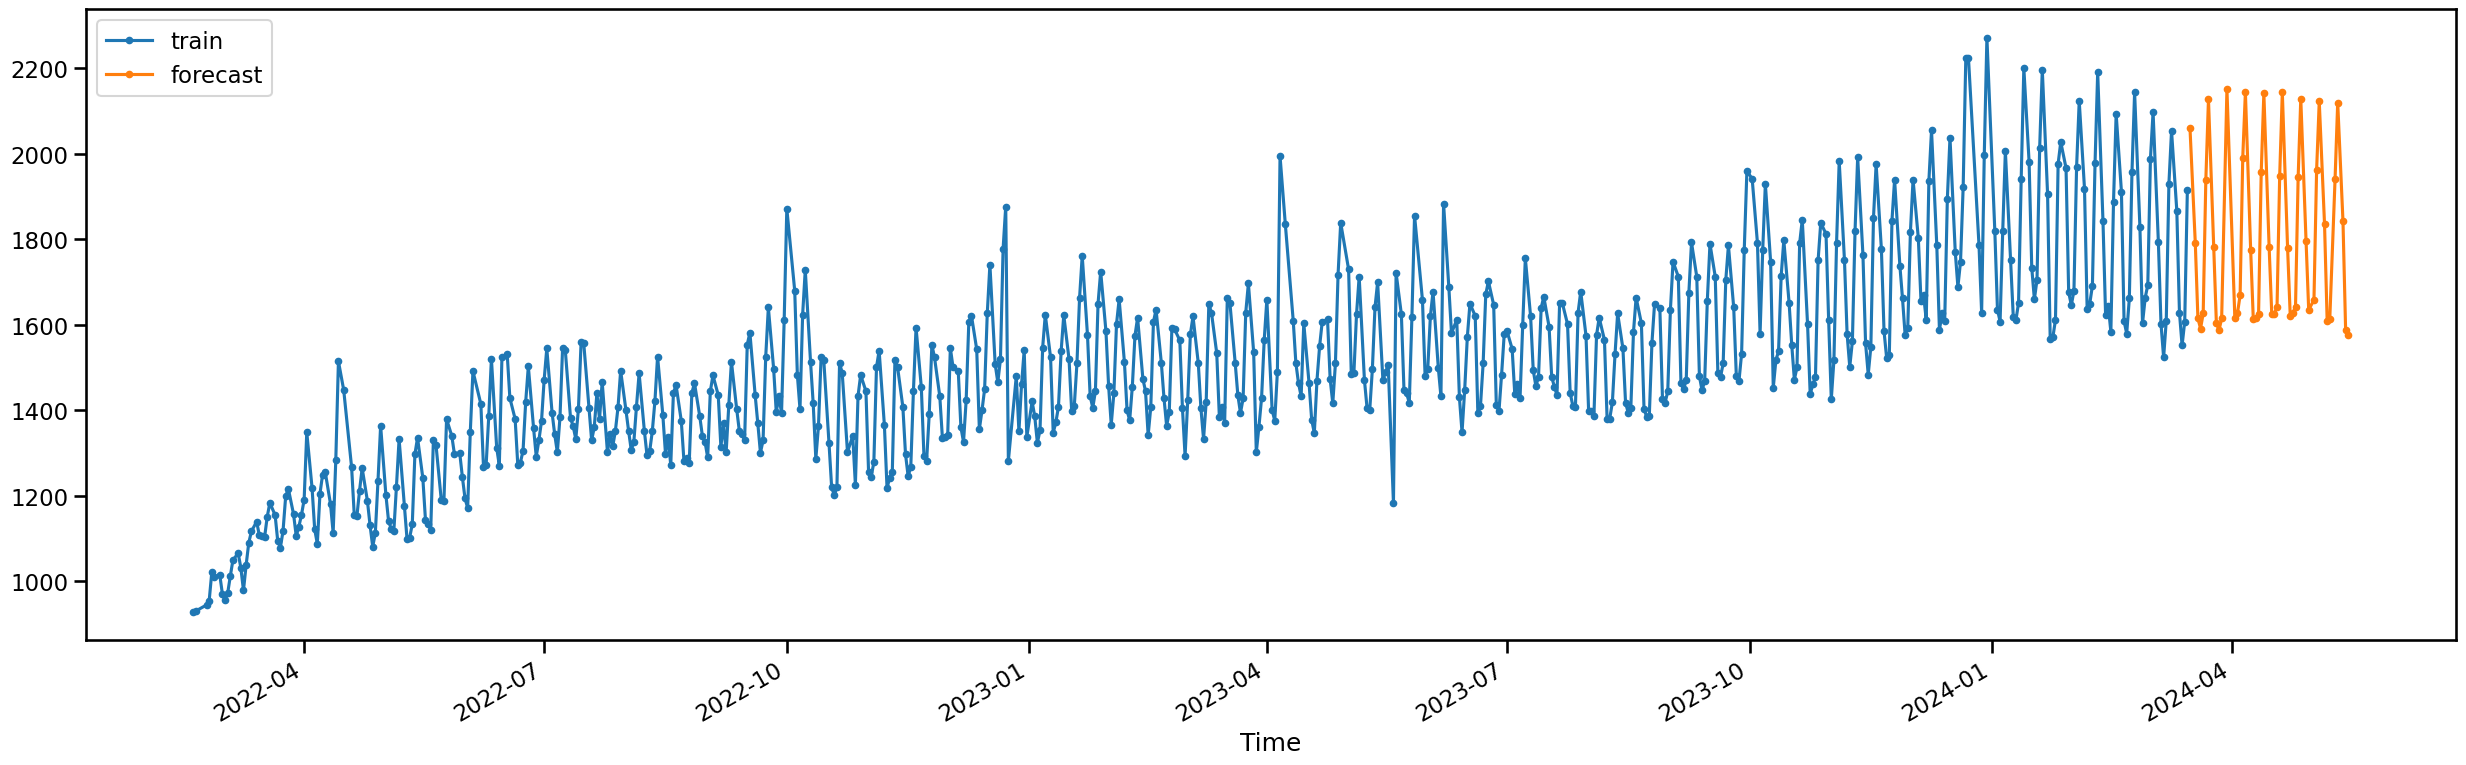

In [113]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
df_forecast.query("split=='test'").plot(
    y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax
)
ax.set_xlabel("Time")
# ax.set_ylabel("Air passengers (1000s)")
# ax.set_title("Air passenger numbers")
ax.legend(["train", "forecast"])
plt.tight_layout()

# for all the data


In [120]:
# load the data
df = load_data()

In [121]:
# df.groupby(TRAIN_LEVEL).apply(
#     train_predict,
#     FEATRURE_COLUMNS,
#     TARGET_COLUMNS,
#     max_lag=365,
#     pipeline=pipeline,
#     pipeline_lags=pipeline_lags,
# )

In [124]:
df.groupby(TRAIN_LEVEL).apply(
    train_predict_sktime,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    max_lag=365,
    pipeline=pipeline,
    pipeline_lags_transformer=lag_window_feats,
    imputation="mean"
)

warehouse: Brno_1
Shape of df_train and df_test before lag transformation (1197, 18) (61, 18)
Shape of df_train  only for lags (1197, 5)
column names:  Index(['y_lag_1', 'y_lag_7', 'y_lag_365', 'y_mean_1_7', 'y_mean_365_7'], dtype='object')
Shape of df_train after lag transformation (1193, 23)
Shape of df_train after droping the nulls (823, 23)
warehouse: Budapest_1
Shape of df_train and df_test before lag transformation (1196, 18) (61, 18)
Shape of df_train  only for lags (1196, 5)
column names:  Index(['y_lag_1', 'y_lag_7', 'y_lag_365', 'y_mean_1_7', 'y_mean_365_7'], dtype='object')
Shape of df_train after lag transformation (1154, 23)
Shape of df_train after droping the nulls (796, 23)
warehouse: Frankfurt_1
Shape of df_train and df_test before lag transformation (757, 18) (61, 18)
Shape of df_train  only for lags (757, 5)
column names:  Index(['y_lag_1', 'y_lag_7', 'y_lag_365', 'y_mean_1_7', 'y_mean_365_7'], dtype='object')
Shape of df_train after lag transformation (629, 23)
Shape

warehouse       orders holiday_name  holiday  shutdown  \
warehouse date                                                                
Brno_1    2024-03-16    Brno_1  9182.302734   no_holiday        0         0   
          2024-03-17    Brno_1  8187.700195   no_holiday        0         0   
          2024-03-18    Brno_1  8227.477539   no_holiday        0         0   
          2024-03-19    Brno_1  8358.456055   no_holiday        0         0   
          2024-03-20    Brno_1  8444.336914   no_holiday        0         0   
...                        ...          ...          ...      ...       ...   
Prague_3  2024-05-11  Prague_3  5714.461914   no_holiday        0         0   
          2024-05-12  Prague_3  5484.274902   no_holiday        0         0   
          2024-05-13  Prague_3  5360.880859   no_holiday        0         0   
          2024-05-14  Prague_3  5184.764160   no_holiday        0         0   
          2024-05-15  Prague_3  5178.681152   no_holiday        0         0   

                      mini_shutdown  shops_closed  winter_school_holidays  \
warehouse date                                                              
Brno_1    2024-03-16              0             0                       0   
          2024-03-17              0             0                       0   
          2024-03-18              0             0                       0   
          2024-03-19              0             0                       0   
          2024-03-20              0             0                       0   
...                             ...           ...                     ...   
Prague_3  2024-05-11              0             0                       0   
          2024-05-12              0             0                       0   
          2024-05-13              0             0                       0   
          2024-05-14              0             0                       0   
          2024-05-15              0             0                       0   

                      school_holidays  blackout  ...  snow  \
warehouse date                                   ...         
Brno_1    2024-03-16                0         0  ...     0   
          2024-03-17                0         0  ...     0   
          2024-03-18                0         0  ...     0   
          2024-03-19                0         0  ...     0   
          2024-03-20                0         0  ...     0   
...                               ...       ...  ...   ...   
Prague_3  2024-05-11                0         0  ...     0   
          2024-05-12                0         0  ...     0   
          2024-05-13                0         0  ...     0   
          2024-05-14                0         0  ...     0   
          2024-05-15                0         0  ...     0   

                                       id  missing  year month  day_of_month  \
warehouse date                                                                 
Brno_1    2024-03-16    Brno_1_2024-03-16        0  2024     3            16   
          2024-03-17    Brno_1_2024-03-17        0  2024     3            17   
          2024-03-18    Brno_1_2024-03-18        0  2024     3            18   
          2024-03-19    Brno_1_2024-03-19        0  2024     3            19   
          2024-03-20    Brno_1_2024-03-20        0  2024     3            20   
...                                   ...      ...   ...   ...           ...   
Prague_3  2024-05-11  Prague_3_2024-05-11        0  2024     5            11   
          2024-05-12  Prague_3_2024-05-12        0  2024     5            12   
          2024-05-13  Prague_3_2024-05-13        0  2024     5            13   
          2024-05-14  Prague_3_2024-05-14        0  2024     5            14   
          2024-05-15  Prague_3_2024-05-15        0  2024     5            15   

                      day_of_week  day_of_year  weekend  split  
warehouse date                                                  
Brno_1    202